# Notebook for clustering on HPC data gathered from CFD folders
## This notebook takes data generated by the module runcrawler and gets statistics out of them

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set(font_scale=1.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Here we create a dataframe from all the json files gathered by runcrawler.py in the DATABASE folder.

In [3]:
df = pd.DataFrame()
for filename in glob.glob('./DATABASE/*.json'):
    with open(filename) as json_file:
        data = json.load(json_file)
        new = json_normalize(data['log_monitoring'][0]['contents'])
        new['User_name'] = filename.split('__')[3]
        df= pd.concat([df, new])

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


We add an index for each run. So when we visualize the head of the dataframe (i.e. the 5 first lines, 
we see each line is a run, each column is a run feature.)

In [4]:
ind = np.arange(0, len(df), 1)
ind = pd.Series(ind)
df['index_run'] = ind.values
df = df.set_index('index_run')

In [5]:
df.head()

User_name        creation_time                   err_log params.CFL  \
index_run                                                                       
0             dupuy  2019-06-24T02:03:28  [before wrap up\n ok, 0]   70000000   
1            potier  2019-02-26T11:55:11  [before wrap up\n ok, 0]   70000000   
2             rossi  2019-04-24T13:26:27  [before wrap up\n ok, 0]   00000000   
3           gullaud  2020-07-31T09:40:10  [before wrap up\n ok, 0]   70000000   
4            potier  2019-05-15T14:01:25  [before wrap up\n ok, 0]   70000000   

          params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                       no                                no   
2                     wale                     Colin_species   
3                     wale                     colin_species   
4                       no                           jameson   

          params.convection_scheme   params.mixture_name params.ncell_group  \
index_run                                                                     
0                             TTGC            KERO_LUCHE                100   
1                               LW                   AIR                100   
2                             TTGC            KERO_LUCHE                100   
3                             TTGC                  C3H8                 60   
4                               LW  N2_qpf_poiseuille_2D                 40   

          params.partitioner  ...  vars.dimension  vars.elapsed_time  \
index_run                     ...                                      
0                   parmetis  ...             3.0           41677.42   
1                   parmetis  ...             2.0              16.12   
2                   parmetis  ...             3.0           41567.26   
3                   parmetis  ...             3.0             157.55   
4                   parmetis  ...             2.0              17.93   

          vars.final_iteration vars.initial_iteration  vars.initial_time  \
index_run                                                                  
0                    2084205.0              2054791.0           0.085092   
1                       7854.0                    0.0           0.000000   
2                          NaN              2993062.0           0.177500   
3                        100.0                    0.0           0.000000   
4                      17565.0                    0.0           0.000000   

          vars.mesh_cells  vars.nodes  vars.number_of_probes  \
index_run                                                      
0              45486233.0   8064050.0                  122.0   
1                 48450.0     24576.0                    NaN   
2              45469910.0   8043365.0                    3.0   
3              19616196.0   3452844.0                   72.0   
4                   400.0       441.0                    2.0   

           vars.physical_time  vars.time_per_ite  
index_run                                         
0                    0.086242             1.4165  
1                    0.120003             0.0020  
2                         NaN             0.3364  
3                    0.000011             1.5336  
4                    0.000311             0.0009  

[5 rows x 28 columns]

In [6]:
df.User_name.unique()

array(['dupuy', 'potier', 'rossi', 'gullaud', 'pouech'], dtype=object)

In [7]:
# Anonymisation des user names
dict = { 'gullaud': 'User 1', 'rossi': 'User 2', 
        'pouech': 'User 3', 'dupuy': 'User 4', 'potier': 'User 5' }

df['User_name'] = df['User_name'].map(dict)

In [8]:
print('The dataframe contains', len(df), 'runs and contains',  len(df.columns), 'features or run parameters')

The dataframe contains 217 runs and contains 28 features or run parameters


## Data cleaning: 
- some filling of NaN values# some filling of NaN values

In [9]:
df.isnull().sum()

User_name                              0
creation_time                          0
err_log                                0
params.CFL                             0
params.LES_model                       0
params.artificial_viscosity_model      0
params.convection_scheme               0
params.mixture_name                    0
params.ncell_group                     8
params.partitioner                     9
params.reactive_flow                   0
params.real_gas                      109
params.smu2                            3
params.solver_type                     0
params.two_phase_flow                151
vars.AVBP_version                     24
vars.CPU_time_s                       36
vars.MPI_processes                    29
vars.dimension                         5
vars.elapsed_time                     28
vars.final_iteration                  34
vars.initial_iteration                 7
vars.initial_time                      7
vars.mesh_cells                        6
vars.nodes      

In [10]:
# un run qui a Nan en nb of probes est un run qui n'a pas de probes
df['vars.number_of_probes'] = df['vars.number_of_probes'].fillna(0.0)
df['params.real_gas'] = df['params.real_gas'].fillna(0.0)
# un run qui n'a pas tourné a 0 en CPU_time ...
df['vars.CPU_time_s'] = df['vars.CPU_time_s'].fillna(0.0)
df['params.two_phase_flow'] = df['params.two_phase_flow'].fillna(0.0)
df['vars.physical_time'] = df['vars.physical_time'].fillna(0.0)
df['vars.elapsed_time'] = df['vars.elapsed_time'].fillna(0.0)
df['vars.final_iteration'] = df['vars.final_iteration'].fillna(0.0)
df['vars.initial_time'] = df['vars.initial_time'].fillna(0.0)
df['params.smu2'] = df['params.smu2'].fillna(0.0)
df['vars.time_per_ite'] = df['vars.time_per_ite'].fillna(0.0)

# si LES = no alors on remplace par DNS.
df['params.LES_model'] = df['params.LES_model'].apply(lambda x: 'DNS' if x=='no' else x )

# traitement de la redondance Colin_species vs colin_species
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'no visc model' if x =='no' else x)
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'colin_species' if x == 'Colin_species' else x)
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'Jameson' if x == 'jameson' else x)

df['params.solver_type'] = df['params.solver_type'].apply(lambda x: 'ns' if (x =='NS' or x =='Ns') else x)

df = df.dropna(subset=['vars.nodes'])

df = df.dropna(subset=['vars.time_per_ite'])
df = df.dropna(subset=['vars.MPI_processes'])
df = df.dropna(subset=['params.ncell_group'])

df['vars.nodes'] = df['vars.nodes'].apply(lambda x: int(x))
df['vars.dimension'] = df['vars.dimension'].apply(lambda x: int(x))
df['vars.MPI_processes'] = df['vars.MPI_processes'].apply(lambda x: int(x))
df['params.ncell_group'] = df['params.ncell_group'].apply(lambda x: int(x))
df['params.smu2'] = df['params.smu2'].apply(lambda x: float(x))

In [11]:
df.isnull().sum()

User_name                            0
creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   1
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               1
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes    

In [12]:
df = df.dropna(subset=['vars.nodes'])
df = df.dropna(subset=['vars.time_per_ite'])
df = df.dropna(subset=['vars.MPI_processes'])
df = df.dropna(subset = ['params.ncell_group'])
df['vars.nodes'] = df['vars.nodes'].apply(lambda x: int(x))
df['vars.dimension'] = df['vars.dimension'].apply(lambda x: int(x))
df['vars.MPI_processes'] = df['vars.MPI_processes'].apply(lambda x: int(x))
df['params.ncell_group'] = df['params.ncell_group'].apply(lambda x: int(x))
df['vars.time_per_ite'] = df['vars.time_per_ite'].fillna(0.0)

In [13]:
df = df.dropna()

In [14]:
df.isnull().sum()

User_name                            0
creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   0
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               0
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes    

# Separation en deux dataframes

## creation de deux dataframe, un pour le setup, un pour le résultat 

On sépare le dataframe en un dataframe de setup du run , majoritairement les parametres lus dans run.params, et un dataframe qui contient plus des valeurs qui sortent du avbp.o

In [15]:
run_setup = ['params.CFL', 'params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name', 'params.ncell_group', 'params.partitioner',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version', 
        'vars.MPI_processes', 'vars.dimension', 
       'vars.nodes', 'vars.number_of_probes']

In [16]:
run_setup

['params.CFL',
 'params.LES_model',
 'params.artificial_viscosity_model',
 'params.convection_scheme',
 'params.mixture_name',
 'params.ncell_group',
 'params.partitioner',
 'params.reactive_flow',
 'params.real_gas',
 'params.smu2',
 'params.solver_type',
 'params.two_phase_flow',
 'vars.AVBP_version',
 'vars.MPI_processes',
 'vars.dimension',
 'vars.nodes',
 'vars.number_of_probes']

In [17]:
run_result = ['creation_time', 'err_log','vars.CPU_time_s', 'vars.elapsed_time', 'vars.final_iteration', 'vars.initial_iteration',
       'vars.initial_time', 'vars.physical_time', 'vars.time_per_ite', 'User_name', 'vars.AVBP_version' ]

In [18]:
run_result

['creation_time',
 'err_log',
 'vars.CPU_time_s',
 'vars.elapsed_time',
 'vars.final_iteration',
 'vars.initial_iteration',
 'vars.initial_time',
 'vars.physical_time',
 'vars.time_per_ite',
 'User_name',
 'vars.AVBP_version']

In [19]:
df_setup = df[run_setup]

In [20]:
df_log = df[run_result]

In [21]:
df_setup.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           70000000            sigma                             colin   
1           70000000              DNS                     no visc model   
2           00000000             wale                     colin_species   
3           70000000             wale                     colin_species   
5           70000000            sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                             TTGC          KERO_LUCHE                 100   
1                               LW                 AIR                 100   
2                             TTGC          KERO_LUCHE                 100   
3                             TTGC                C3H8                  60   
5                               LW                 AIR                 100   

          params.partitioner  params.reactive_flow  params.real_gas  \
index_run                                                             
0                   parmetis                     1              0.0   
1                   parmetis                     0              0.0   
2                   parmetis                     1              0.0   
3                   parmetis                     1              0.0   
5                   parmetis                     0              0.0   

           params.smu2 params.solver_type  params.two_phase_flow  \
index_run                                                          
0                  1.0                 ns                    0.0   
1                  0.0                 ns                    0.0   
2                  1.0                 ns                    0.0   
3                  0.0                 ns                    0.0   
5                  0.0                 ns                    0.0   

          vars.AVBP_version  vars.MPI_processes  vars.dimension  vars.nodes  \
index_run                                                                     
0                     7.3.0                 360               3     8064050   
1                     7.3.0                  24               2       24576   
2                     7.3.0                1120               3     8043365   
3                     7.6.0                 540               3     3452844   
5                     7.3.0                   2               3        9704   

           vars.number_of_probes  
index_run                         
0                          122.0  
1                            0.0  
2                            3.0  
3                           72.0  
5                            1.0

In [22]:
df_setup.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           70000000            sigma                             colin   
1           70000000              DNS                     no visc model   
2           00000000             wale                     colin_species   
3           70000000             wale                     colin_species   
5           70000000            sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                             TTGC          KERO_LUCHE                 100   
1                               LW                 AIR                 100   
2                             TTGC          KERO_LUCHE                 100   
3                             TTGC                C3H8                  60   
5                               LW                 AIR                 100   

          params.partitioner  params.reactive_flow  params.real_gas  \
index_run                                                             
0                   parmetis                     1              0.0   
1                   parmetis                     0              0.0   
2                   parmetis                     1              0.0   
3                   parmetis                     1              0.0   
5                   parmetis                     0              0.0   

           params.smu2 params.solver_type  params.two_phase_flow  \
index_run                                                          
0                  1.0                 ns                    0.0   
1                  0.0                 ns                    0.0   
2                  1.0                 ns                    0.0   
3                  0.0                 ns                    0.0   
5                  0.0                 ns                    0.0   

          vars.AVBP_version  vars.MPI_processes  vars.dimension  vars.nodes  \
index_run                                                                     
0                     7.3.0                 360               3     8064050   
1                     7.3.0                  24               2       24576   
2                     7.3.0                1120               3     8043365   
3                     7.6.0                 540               3     3452844   
5                     7.3.0                   2               3        9704   

           vars.number_of_probes  
index_run                         
0                          122.0  
1                            0.0  
2                            3.0  
3                           72.0  
5                            1.0

In [23]:
df_log.head()

creation_time                   err_log  vars.CPU_time_s  \
index_run                                                                   
0          2019-06-24T02:03:28  [before wrap up\n ok, 0]       15000000.0   
1          2019-02-26T11:55:11  [before wrap up\n ok, 0]            386.8   
2          2019-04-24T13:26:27  [before wrap up\n ok, 0]       46560000.0   
3          2020-07-31T09:40:10  [before wrap up\n ok, 0]          85080.0   
5          2019-12-12T18:33:59  [before run params, 110]            654.9   

           vars.elapsed_time  vars.final_iteration  vars.initial_iteration  \
index_run                                                                    
0                   41677.42             2084205.0               2054791.0   
1                      16.12                7854.0                     0.0   
2                   41567.26                   0.0               2993062.0   
3                     157.55                 100.0                     0.0   
5                     327.47                5039.0                     0.0   

           vars.initial_time  vars.physical_time  vars.time_per_ite User_name  \
index_run                                                                       
0                   0.085092            0.086242             1.4165    User 4   
1                   0.000000            0.120003             0.0020    User 5   
2                   0.177500            0.000000             0.3364    User 2   
3                   0.000000            0.000011             1.5336    User 1   
5                   0.000000            0.002761             0.0648    User 5   

          vars.AVBP_version  
index_run                    
0                     7.3.0  
1                     7.3.0  
2                     7.3.0  
3                     7.6.0  
5                     7.3.0

# User's habits

In this section runs are going to be sorted by year, hour and day when they were created.
This helps to see the user's habits for optimization of his access to the clusters.

In [24]:
df_log['time'] = pd.to_datetime(df_log['creation_time'])

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_log.columns 

Index(['creation_time', 'err_log', 'vars.CPU_time_s', 'vars.elapsed_time',
       'vars.final_iteration', 'vars.initial_iteration', 'vars.initial_time',
       'vars.physical_time', 'vars.time_per_ite', 'User_name',
       'vars.AVBP_version', 'time'],
      dtype='object')

In [26]:
df_log['Hour'] = df_log['time'].apply(lambda time: time.hour)
df_log['Month'] = df_log['time'].apply(lambda time: time.month)
df_log['Day of Week'] = df_log['time'].apply(lambda time: time.dayofweek)
df_log['year'] = df_log['time'].apply(lambda time: time.year)

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [27]:
dict_semaine = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

In [28]:
semaine = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [29]:
df_log['Day of Week'] = df_log['Day of Week'].map(dict_semaine)

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
dict_year = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
             9: 'September', 10: 'October', 11: 'November', 12: 'December'}

In [31]:
year = dict_year.values()
hours = np.arange(1,25)
hours

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [32]:
year

dict_values(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

In [33]:
df_log['Month'] = df_log['Month'].map(dict_year)

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


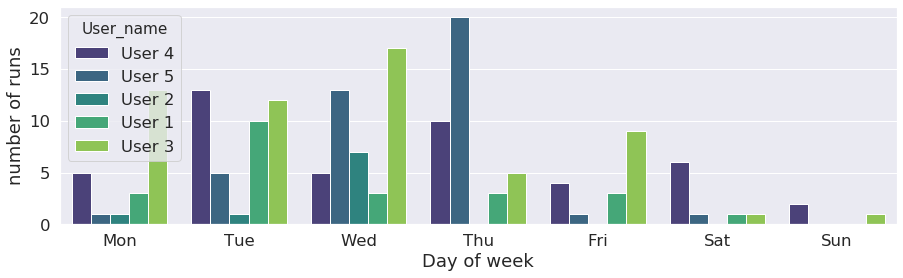

<Figure size 720x432 with 0 Axes>

In [34]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(1,1,1)
sns.countplot(x='Day of Week',data=df_log, 
              order= semaine,palette='viridis', hue = df_log['User_name'])
ax.set_xlabel('Day of week')
ax.set_ylabel('number of runs')
fig = plt.figure(figsize = (10,6))

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

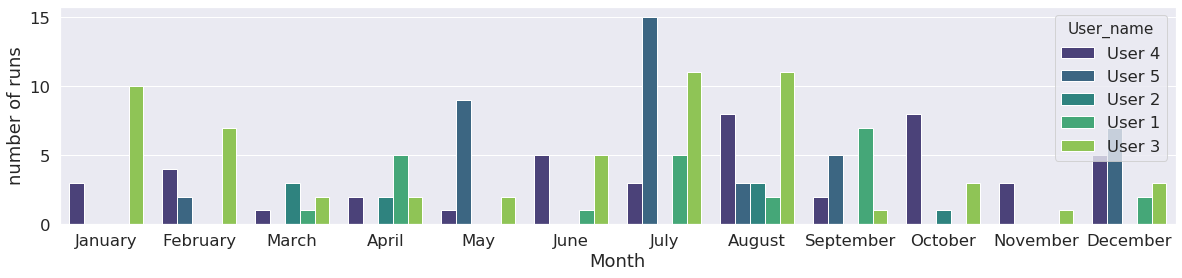

<Figure size 720x432 with 0 Axes>

In [35]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize = (20,4))
ax = fig.add_subplot(1,1,1)
sns.countplot(x='Hour',data=df_log, order = hours, 
              hue = df_log['User_name'], palette='viridis')
ax.set_xlabel('Hour')
ax.set_ylabel('number of runs')
fig = plt.figure(figsize = (10,6))

sns.set(font_scale=1.5)
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)
sns.countplot(x='year',data=df_log, hue = df_log['User_name'], palette='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('number of runs')
fig = plt.figure(figsize = (10,6))

sns.set(font_scale=1.5)
fig = plt.figure(figsize = (20,4))
ax = fig.add_subplot(1,1,1)
sns.countplot(x='Month',data=df_log, order = year, 
              hue = df_log['User_name'],
              palette='viridis')
ax.set_xlabel('Month')
ax.set_ylabel('number of runs')
fig = plt.figure(figsize = (10,6))

In [36]:
df_log.columns

Index(['creation_time', 'err_log', 'vars.CPU_time_s', 'vars.elapsed_time',
       'vars.final_iteration', 'vars.initial_iteration', 'vars.initial_time',
       'vars.physical_time', 'vars.time_per_ite', 'User_name',
       'vars.AVBP_version', 'time', 'Hour', 'Month', 'Day of Week', 'year'],
      dtype='object')

In [37]:
array = np.array(df_log['vars.AVBP_version'].unique())

In [38]:
np.sort(array)

array(['7.1.0', '7.2.0', '7.3.0', '7.4.0', '7.5.0', '7.6.0'], dtype=object)

In [39]:
df_log.year.unique()

array([2019, 2020, 2018])

In [40]:
df_log2019 = df_log[df_log['year'] ==2019]
df_log2018 = df_log[df_log['year'] ==2018]
df_log2020 = df_log[df_log['year'] ==2020]

In [41]:
df_log2020['year'].unique()

array([2020])

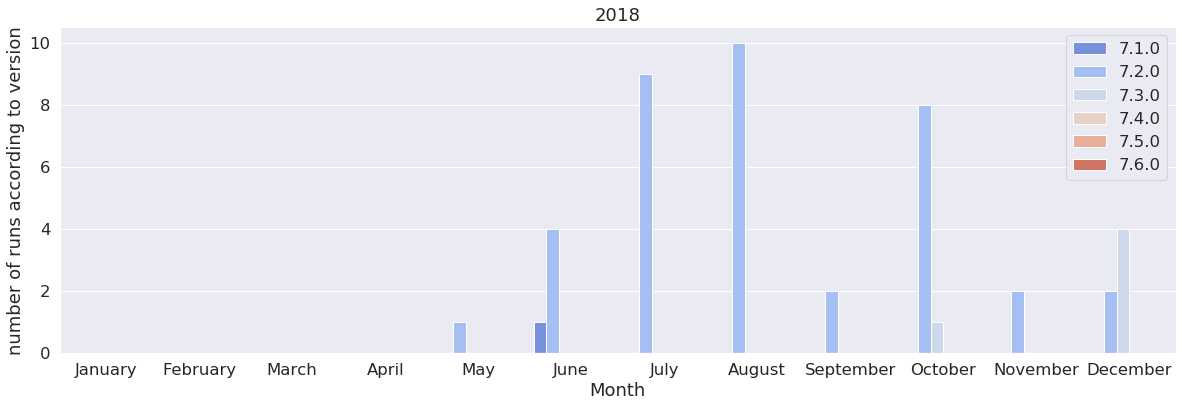

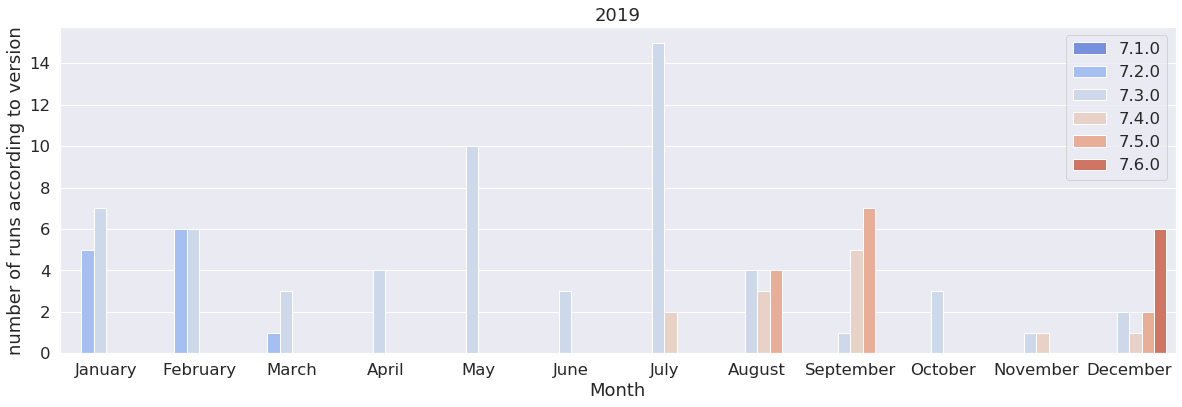

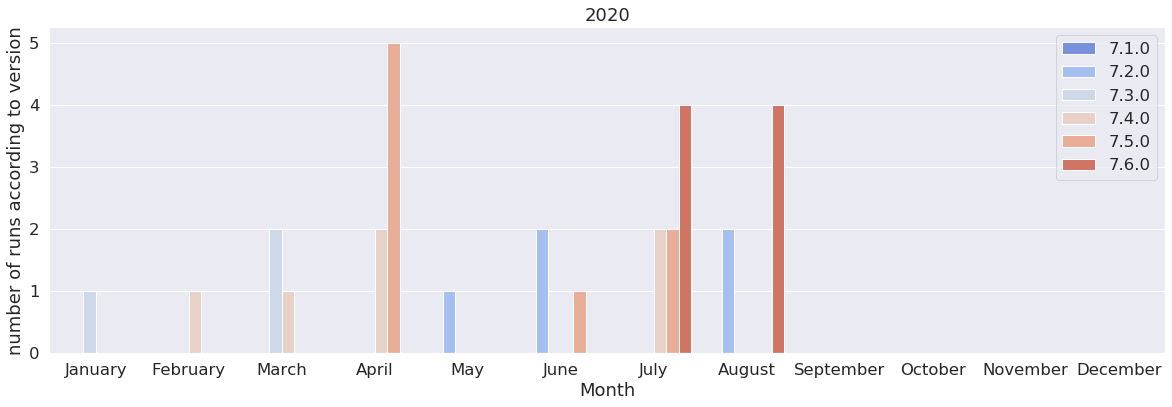

In [42]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)

sns.countplot(x = 'Month', data = df_log2018, hue = 'vars.AVBP_version', 
              order = year, hue_order= np.sort(array), palette = 'coolwarm')

ax.set_xlabel('Month')
ax.set_ylabel('number of runs according to version')
ax.set_title('2018')
ax.legend(loc = 1)

fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
sns.countplot(x = 'Month', data = df_log2019, hue = 'vars.AVBP_version', 
              order = year, hue_order= np.sort(array), palette = 'coolwarm')
ax.set_xlabel('Month')
ax.set_ylabel('number of runs according to version')
ax.set_title('2019')
ax.legend(loc = 1)

fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
sns.countplot(x = 'Month', data = df_log2020, hue = 'vars.AVBP_version', 
              order = year, hue_order= np.sort(array), palette = 'coolwarm')
ax.set_xlabel('Month')
ax.set_ylabel('number of runs according to version')
ax.set_title('2020')
ax.legend(loc = 1)

## Burned hours by User

In [43]:
#We add a new column to the dataframe df_log --> CPU time converted in hours for lisibility
df_log['vars.CPU_time_h'] = df_log['vars.CPU_time_s']/3600
df_log['vars.CPU_time_h']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


index_run
0       4166.666667
1          0.107444
2      12933.333333
3         23.633333
5          0.181917
6       4061.111111
7       4166.666667
8          2.451944
10      4166.666667
11         7.277778
13        38.305556
14      5122.222222
15         3.766667
16       430.833333
17     13227.777778
20      4233.333333
21         0.000000
22         0.325833
24      4166.666667
25         0.000000
26      4166.666667
27         0.325833
28      2268.333333
29         2.451944
30         0.000156
31       396.666667
32         0.125222
33         0.264944
36       306.388889
38         0.364722
           ...     
180     6094.444444
181     4200.000000
182     6258.333333
183     4169.444444
184        2.229444
186        0.532778
187    11350.000000
188      386.388889
189        4.519444
190       24.283333
191     4166.666667
192     4200.000000
194        0.532778
195        0.006033
196        0.263583
197     4200.000000
199        2.451944
200       24.283333
201    133

In [44]:
df_log.columns

Index(['creation_time', 'err_log', 'vars.CPU_time_s', 'vars.elapsed_time',
       'vars.final_iteration', 'vars.initial_iteration', 'vars.initial_time',
       'vars.physical_time', 'vars.time_per_ite', 'User_name',
       'vars.AVBP_version', 'time', 'Hour', 'Month', 'Day of Week', 'year',
       'vars.CPU_time_h'],
      dtype='object')

In [45]:
df_log.groupby('User_name').sum()['vars.CPU_time_h']

User_name
User 1      9404.288000
User 2     63977.788631
User 3     26036.759899
User 4    192533.248687
User 5        77.488996
Name: vars.CPU_time_h, dtype: float64

Text(0, 0.5, 'CPU hours used')

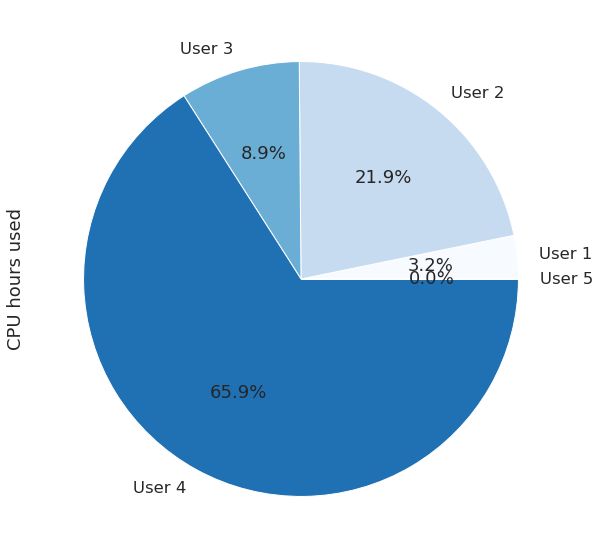

In [46]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
df_log.groupby('User_name').sum()['vars.CPU_time_h'].plot(kind='pie', autopct='%1.1f%%',
                                                   cmap = 'Blues')
ax.set_ylabel('CPU hours used')

In [47]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
df['User_name'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%',
                                                   cmap = 'Blues')
ax.set_ylabel('Percentage of runs per user')
#state=['converged', 'not converged']
#plt.legend(['converged', 'not converged'])

Text(0, 0.5, 'Percentage of runs per user')

In [48]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize = (25,10))
ax = fig.add_subplot(1,1,1)
dummies_avbpversion = pd.get_dummies(df_log['vars.AVBP_version'])

df_avbpv = pd.concat([df_log.drop('vars.AVBP_version', axis = 1), dummies_avbpversion], axis=1)
df_avbpv
df_avbpv.columns
df_heatmap = df_avbpv[dummies_avbpversion.columns]
df_heatmap
#sns.countplot(x='Month',data=df_heatmap, palette='viridis')
df_heatmap = pd.concat([df_heatmap, df_log['Month']], axis = 1)
df_heatmap.groupby('Month').sum()
sns.heatmap(df_heatmap.groupby('Month').sum(),
            annot = True, cmap = "Blues",
            lw = 0.4)
#ax.set_xlabel('Mixture')
#ax.set_ylabel('Dimension')

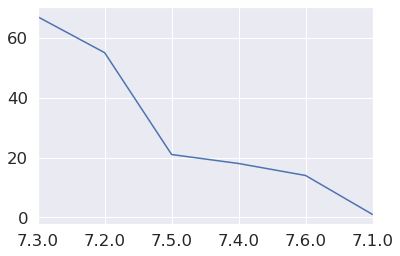

In [49]:
df['vars.AVBP_version'].value_counts().plot()

# Statistics on runs launched depending on their parameters

## Number of runs depending on Mixture name

Text(0, 0.5, 'number of runs')

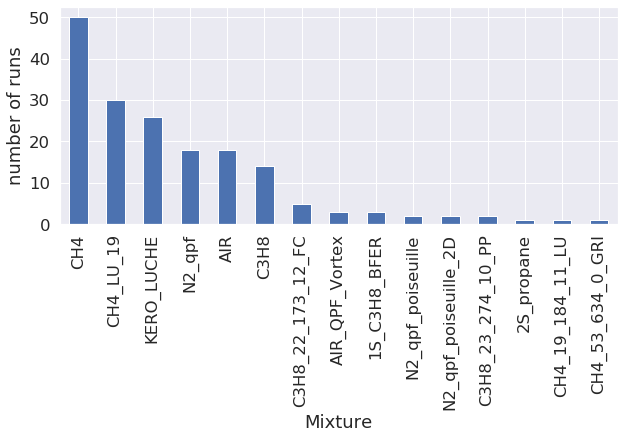

In [50]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1,1,1)
#sns.countplot(x = 'params.mixture_name', data = df_setup)
df_setup['params.mixture_name'].value_counts().plot(kind = 'bar')
ax.set_xlabel('Mixture')
ax.set_ylabel('number of runs')

## Number of runs depending on dimension

In [51]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1,1,1)
df_setup['vars.dimension'].value_counts().plot(kind = 'bar')
ax.set_xlabel('Dimension')
ax.set_ylabel('number of runs')

Text(0, 0.5, 'number of runs')

In [52]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1)
#df_setup['vars.AVBP_version'].value_counts().plot(kind = 'bar')
sns.countplot(x='vars.AVBP_version',data=df_log, hue = df_log['User_name'], palette='viridis')
ax.set_xlabel('AVBP_version')
ax.set_ylabel('number of runs')

Text(0, 0.5, 'number of runs')

## Number of runs depending on dimension colored by mixture_name

In [53]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize = (25,10))
ax = fig.add_subplot(1,1,1)
dummies_mixturename = pd.get_dummies(df['params.mixture_name'])
df_pca = pd.concat([df.drop('params.mixture_name', axis = 1), dummies_mixturename], axis=1)
df_pca.groupby('vars.dimension').count()
df_heatmap = df_pca[dummies_mixturename.columns]
df_heatmap = pd.concat([df_heatmap, df['vars.dimension']], axis = 1)
df_heatmap.groupby('vars.dimension').sum()
sns.heatmap(df_heatmap.groupby('vars.dimension').sum(),
            annot = True, cmap = "Blues", 
            lw = 0.4)
ax.set_xlabel('Mixture')
ax.set_ylabel('Dimension')

Text(196.5, 0.5, 'Dimension')

## Number of runs depending on artificial viscosity model

In [54]:
sns.set_style("whitegrid")
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(1,1,1)
df_setup['params.artificial_viscosity_model'].value_counts().plot(kind = 'bar')
ax.set_xlabel('Artificial viscosity model')
ax.set_ylabel('number of runs')

Text(0, 0.5, 'number of runs')

## Number or runs depending on LES model

Text(0, 0.5, 'number of runs')

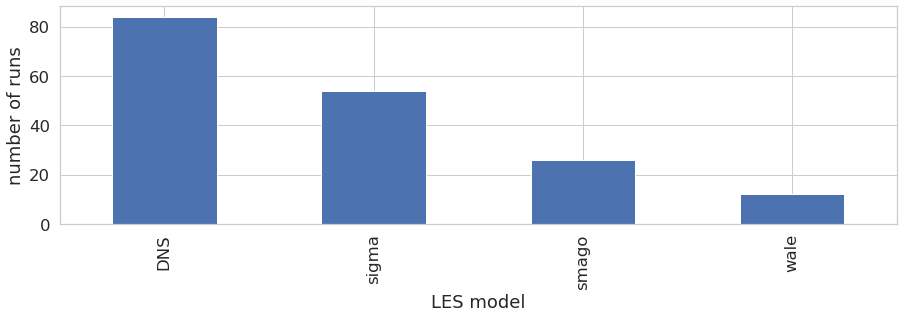

In [55]:
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(1,1,1)
df_setup['params.LES_model'].value_counts().plot(kind = "bar")
ax.set_xlabel('LES model')
ax.set_ylabel('number of runs')


## Cross plot of LES Model and artificial viscosity model

In [56]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
dummies_LESmodel = pd.get_dummies(df['params.LES_model'])
print(dummies_LESmodel.columns)
df_pca2 = pd.concat([df.drop('params.LES_model', axis = 1), dummies_LESmodel], axis=1)
df_heatmap2 = df_pca2[dummies_LESmodel.columns]
df_heatmap2 = pd.concat([df_heatmap2, df['params.artificial_viscosity_model']], axis = 1)
print(df_heatmap2.head())
df_heatmap2.groupby('params.artificial_viscosity_model').sum()
sns.heatmap(df_heatmap2.groupby('params.artificial_viscosity_model').sum(),
            annot = True, cmap = "Blues", 
            lw = 0.4)
ax.set_xlabel('LES model')
ax.set_ylabel('Artificial viscosity model')

Index(['DNS', 'sigma', 'smago', 'wale'], dtype='object')
           DNS  sigma  smago  wale params.artificial_viscosity_model
index_run                                                           
0            0      1      0     0                             colin
1            1      0      0     0                     no visc model
2            0      0      0     1                     colin_species
3            0      0      0     1                     colin_species
5            0      1      0     0                        colin_rhou


Text(60.296874999999986, 0.5, 'Artificial viscosity model')

# Machine usage tendency: HPC statistics

## Mesh number of nodes repartition

In [57]:
fig = plt.figure(figsize = (22,6))
ax = fig.add_subplot(1,1,1)
sns.distplot(df['vars.mesh_cells'])
#df['vars.nodes'].plot.hist(bins=100)
#sns.countplot(x = 'mesh_cells', data = df)
ax.set_xlabel('Mesh cells')
ax.set_ylabel('number of runs')
plt.xscale('log')
#ax.set_xlim(1,1000)

## Number of nodes repartition colored by the number of procs: heatmap

Text(0.5, 61.5, 'MPI processors')

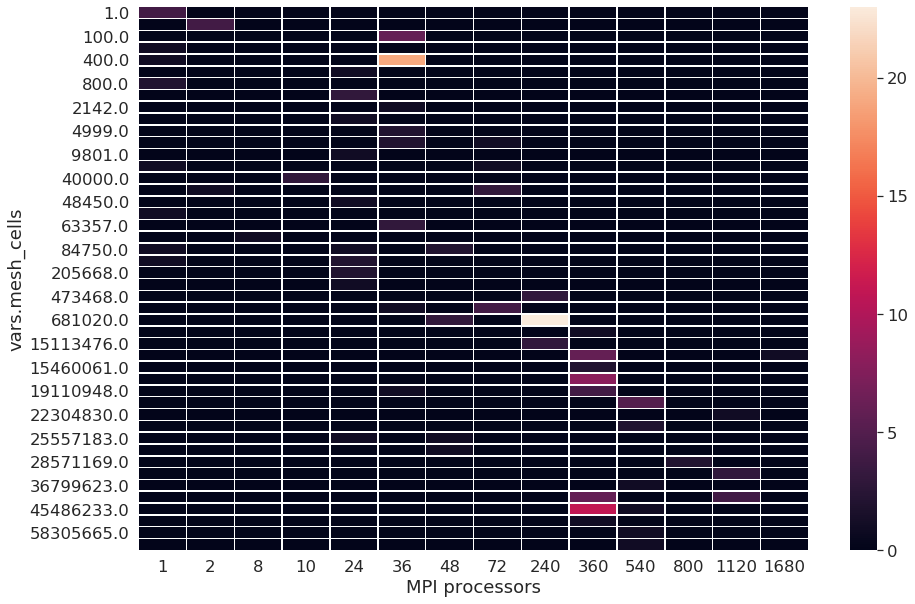

In [58]:
fig = plt.figure(figsize = (15,10))
dummies_MPI_processes = pd.get_dummies(df['vars.MPI_processes'])
ax = fig.add_subplot(1,1,1)
df_pca3 = pd.concat([df.drop('vars.MPI_processes', axis = 1), dummies_MPI_processes], axis=1)
df_scatter = df_pca3.groupby('vars.mesh_cells').sum()[dummies_MPI_processes.columns]
#df_scatter.columns = ['1', '8', '36', '540', '1120']
sns.heatmap(df_scatter, lw=.5)
ax.set_xlabel('MPI processors')


## MPI procs (number of runs by number of procs): User's habits

Text(0, 0.5, 'number of runs')

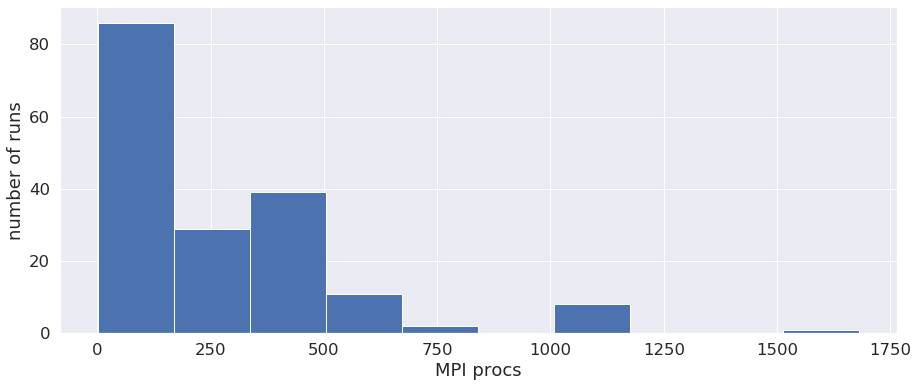

In [59]:
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)
df['vars.MPI_processes'].plot.hist(bins = 10)
ax.set_xlabel('MPI procs')
ax.set_ylabel('number of runs')

masked_array [[9 2 -- -- 13 30 7 2 29 16 -- 2 -- 1]
 [-- -- -- -- -- 3 -- -- -- -- 7 -- -- --]
 [2 3 -- 3 1 2 -- 7 -- 23 4 -- 8 --]
 [-- -- 1 -- -- -- -- -- -- -- -- -- -- --]
 [1 -- -- -- -- -- -- -- -- -- -- -- -- --]]
                    1     2     8     10    24    36    48    72    240   \
params.ncell_group                                                         
40                   9.0   2.0   NaN   NaN  13.0  30.0   7.0   2.0  29.0   
60                   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   
100                  2.0   3.0   NaN   3.0   1.0   2.0   NaN   7.0   NaN   
120                  NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   
400                  1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                    360   540   800   1120  1680  
params.ncell_group                                
40                  16.0   NaN   2.0   NaN   1.0  
60                   NaN   7.0   NaN   NaN   NaN  
100                 23.0   4.0   NaN   8.0

Text(106.5, 0.5, 'Ncell_groups')

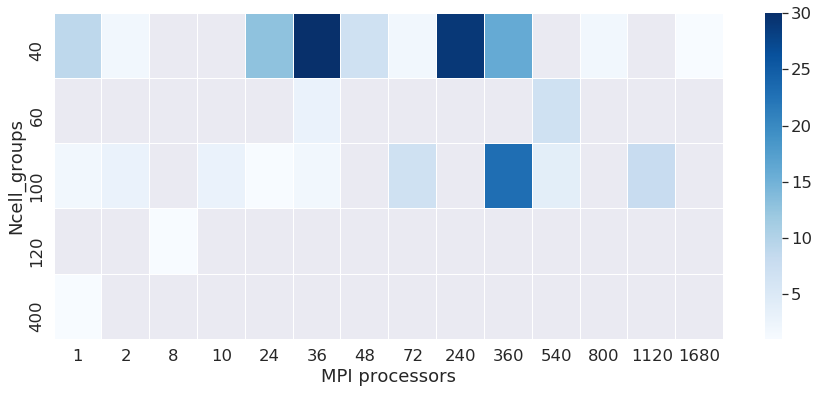

In [60]:
import numpy.ma as ma
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)
dummies_MPI_processes = pd.get_dummies(df['vars.MPI_processes'])
df_pca3 = pd.concat([df.drop('vars.MPI_processes', axis = 1), dummies_MPI_processes], axis=1)
df_scatter = df_pca3.groupby('params.ncell_group').sum()[dummies_MPI_processes.columns]
#print(df_scatter[df_scatter> 0])
#print(df_scatter)
masked_array = ma.masked_where(df_scatter ==0, df_scatter)
print('masked_array', masked_array)
df_scatter = df_scatter[df_scatter >0]
#df_scatter = df_scatter.apply(lambda x: np.log(x))
print(df_scatter)
sns.heatmap(df_scatter[df_scatter >0], lw = 0.1, cmap = 'Blues', )
#sns.heatmap(masked_array, lw = 0.1, cmap = 'Blues')

ax.set_xlabel('MPI processors')
ax.set_ylabel('Ncell_groups')

In [61]:
print(type(df['vars.MPI_processes'][0]))

<class 'numpy.int64'>


Text(106.5, 0.5, 'Dimension')

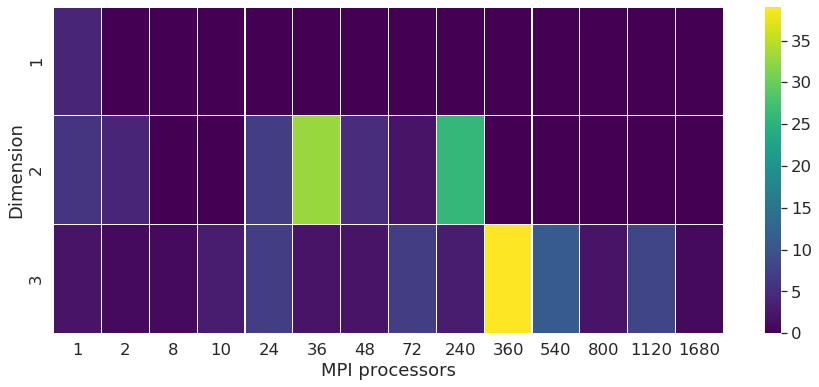

In [62]:
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)
dummies_MPI_processes = pd.get_dummies(df['vars.MPI_processes'])
df_pca3 = pd.concat([df.drop('vars.MPI_processes', axis = 1), dummies_MPI_processes], axis=1)
df_scatter = df_pca3.groupby('vars.dimension').sum()[dummies_MPI_processes.columns]
sns.heatmap(df_scatter, lw = 0.1, cmap = 'viridis')
ax.set_xlabel('MPI processors')
ax.set_ylabel('Dimension')

# Scalability and efficiency

In [63]:
# calcul de l'efficacité (temps passé par coeur /itération pour calculer un point), on sépare par dimension (2D et 3D)
#df['eff'] = df['vars.time_per_ite']*1000000/df['vars.nodes']
df['vars.CPU_time_h'] = df['vars.CPU_time_s']/3600
df_3D = df[df['vars.dimension'] == 3]
df_2D = df[df['vars.dimension'] == 2]
df_3D['eff'] = df_3D['vars.time_per_ite']*1000000/df_3D['vars.nodes']
df_2D['eff'] = df_2D['vars.time_per_ite']*1000000/df_2D['vars.nodes']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## Scalability : evolution of time per iteration when increasing the number of processors

In [64]:
df_3D = df_3D[df_3D['vars.CPU_time_h'] > 0]

In [65]:
df_3D['vars.mesh_cells'] = df_3D['vars.mesh_cells'].apply(lambda x: np.log10(x))

In [66]:
df_3D['vars.CPU_time_h'] = df_3D['vars.CPU_time_h'].apply(lambda x: np.log10(x))

In [67]:
df['vars.CPU_time_h']

index_run
0       4166.666667
1          0.107444
2      12933.333333
3         23.633333
5          0.181917
6       4061.111111
7       4166.666667
8          2.451944
10      4166.666667
11         7.277778
13        38.305556
14      5122.222222
15         3.766667
16       430.833333
17     13227.777778
20      4233.333333
21         0.000000
22         0.325833
24      4166.666667
25         0.000000
26      4166.666667
27         0.325833
28      2268.333333
29         2.451944
30         0.000156
31       396.666667
32         0.125222
33         0.264944
36       306.388889
38         0.364722
           ...     
180     6094.444444
181     4200.000000
182     6258.333333
183     4169.444444
184        2.229444
186        0.532778
187    11350.000000
188      386.388889
189        4.519444
190       24.283333
191     4166.666667
192     4200.000000
194        0.532778
195        0.006033
196        0.263583
197     4200.000000
199        2.451944
200       24.283333
201    133

In [68]:
df_2D_partial=df_2D[df_2D['vars.time_per_ite']>0.0]

In [69]:
import numpy as np

No handles with labels found to put in legend.


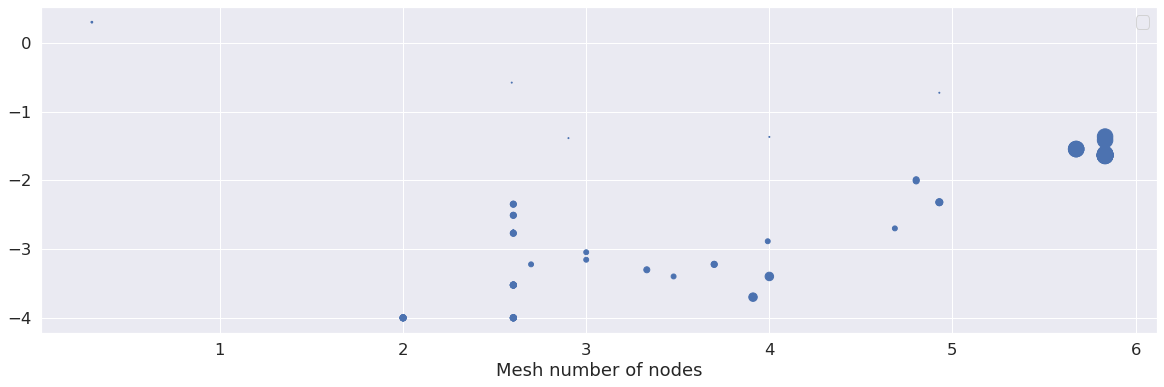

In [70]:

fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
#sns.scatterplot(x =np.log10()'vars.nodes', y = 'vars.time_per_ite', 
#                data = df_2D, ax = ax, #hue = 'vars.MPI_processes', 
#               style ='vars.MPI_processes',
#               palette = "Set2", legend = False)
           #size = 'vars.MPI_processes')
plt.scatter(x =np.log10(df_2D_partial['vars.mesh_cells']), 
            y = np.log10(df_2D_partial['vars.time_per_ite']),
           s = df_2D_partial['vars.MPI_processes'])

ax.set_xlabel('Mesh number of nodes')
#ax.set_ylim(100,200)
#ax.set_ylabel('Time per iteration (ms)')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc = 0)
#plt.show()

In [71]:
min(df_2D_partial['vars.nodes'])

2

In [72]:
df_3D['eff-MPI'] = df_3D['eff']
df_3D['eff-MPI']

index_run
0       0.175656
2       0.041823
3       0.444156
5       6.677659
6       0.175024
7       0.101194
8       0.481424
10      0.103504
11      7.440231
14      0.066879
17      0.030117
20      0.068700
24      0.168600
26      0.096830
28      0.180148
29      0.481424
38      0.286960
41      0.075256
42      0.136961
43      0.074568
45      1.495255
46      0.055872
48      0.879567
50      0.168712
51      0.100809
52      0.028199
55      2.297097
63      0.260081
68      0.097373
77      0.098427
         ...    
129     0.096965
130     0.025063
132     0.096670
145     1.936341
146     0.168290
149     0.634160
150     5.005616
152     0.169667
153     0.100631
154     0.137116
155     0.097150
156     0.097367
157     0.168848
162     0.104764
171     0.097980
174     5.468417
180     0.113194
181     0.097440
182     0.073587
183     0.172801
187     0.025946
190    41.251031
191     0.164359
192     0.096563
195     0.879567
197     0.097513
199     0.481424
200 

In [73]:
df_3D.columns

Index(['User_name', 'creation_time', 'err_log', 'params.CFL',
       'params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name', 'params.ncell_group',
       'params.partitioner', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.solver_type', 'params.two_phase_flow',
       'vars.AVBP_version', 'vars.CPU_time_s', 'vars.MPI_processes',
       'vars.dimension', 'vars.elapsed_time', 'vars.final_iteration',
       'vars.initial_iteration', 'vars.initial_time', 'vars.mesh_cells',
       'vars.nodes', 'vars.number_of_probes', 'vars.physical_time',
       'vars.time_per_ite', 'vars.CPU_time_h', 'eff', 'eff-MPI'],
      dtype='object')

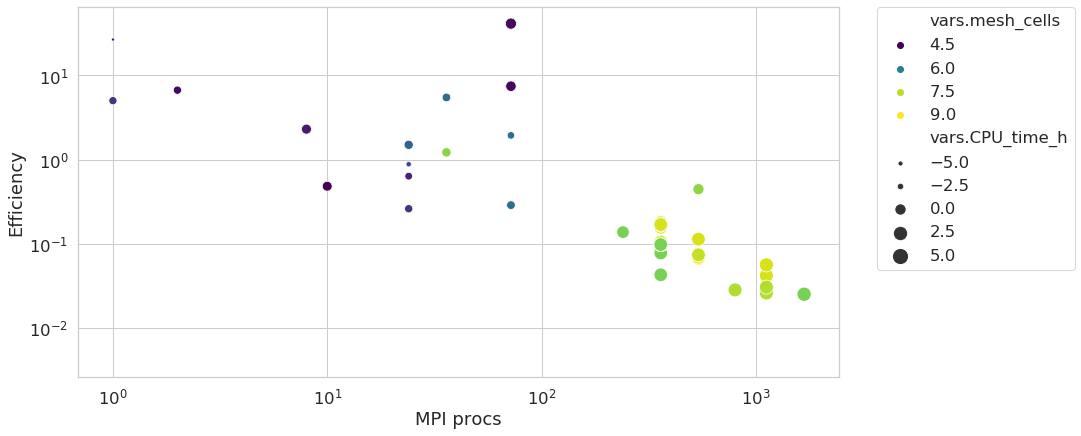

In [85]:
df_3D_partial=df_3D[df_3D['vars.time_per_ite']>0.0]

fig = plt.figure(figsize = (30,15))
sns.set_style('whitegrid')
sns.color_palette()
#ax1 = fig.add_subplot(2,2,1)
#sns.violinplot(x = 'vars.MPI_processes', y = 'eff', data = df_2D, ax = ax1)
#sns.scatterplot(x = 'vars.MPI_processes', y = 'eff', data = df_2D, ax = ax1)

#plt.xscale('log')
#plt.yscale('log')
#ax1.set_xlabel('MPI procs')
#ax1.set_title('2D')
#ax1.set_ylabel('Efficiency')

ax2 = fig.add_subplot(2,2,2)
#sns.violinplot(x = 'vars.MPI_processes', y = 'eff', data = df_3D, ax = ax2)
sns.scatterplot(x = 'vars.MPI_processes', 
                y = 'eff', data = df_3D_partial, ax = ax2, hue = 'vars.mesh_cells',
             size = 'vars.CPU_time_h', sizes = (10,200), 
                 palette = "viridis")

ax2.set_xlabel('MPI procs')
#ax2.set_title('3D')
ax2.set_ylabel('Efficiency')
#ax2.set_xlim([100, 1000])
#ax2.set_ylim([0.01, 0.1])
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(loc = 3)


# Work on error log

We add a column with the error code if the error code is 0, it means that the run is converged.
so we create a column 'CONVERGED' which can take the value 0 or 1.

In [75]:
df['error_code'] = df['err_log'].apply(lambda x: str(x).split(',')[-1][:-1])

In [76]:
df.head()

User_name        creation_time                   err_log params.CFL  \
index_run                                                                       
0            User 4  2019-06-24T02:03:28  [before wrap up\n ok, 0]   70000000   
1            User 5  2019-02-26T11:55:11  [before wrap up\n ok, 0]   70000000   
2            User 2  2019-04-24T13:26:27  [before wrap up\n ok, 0]   00000000   
3            User 1  2020-07-31T09:40:10  [before wrap up\n ok, 0]   70000000   
5            User 5  2019-12-12T18:33:59  [before run params, 110]   70000000   

          params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                      DNS                     no visc model   
2                     wale                     colin_species   
3                     wale                     colin_species   
5                    sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                             TTGC          KERO_LUCHE                 100   
1                               LW                 AIR                 100   
2                             TTGC          KERO_LUCHE                 100   
3                             TTGC                C3H8                  60   
5                               LW                 AIR                 100   

          params.partitioner  ...  vars.final_iteration  \
index_run                     ...                         
0                   parmetis  ...             2084205.0   
1                   parmetis  ...                7854.0   
2                   parmetis  ...                   0.0   
3                   parmetis  ...                 100.0   
5                   parmetis  ...                5039.0   

           vars.initial_iteration  vars.initial_time vars.mesh_cells  \
index_run                                                              
0                       2054791.0           0.085092      45486233.0   
1                             0.0           0.000000         48450.0   
2                       2993062.0           0.177500      45469910.0   
3                             0.0           0.000000      19616196.0   
5                             0.0           0.000000         47491.0   

           vars.nodes vars.number_of_probes  vars.physical_time  \
index_run                                                         
0             8064050                 122.0            0.086242   
1               24576                   0.0            0.120003   
2             8043365                   3.0            0.000000   
3             3452844                  72.0            0.000011   
5                9704                   1.0            0.002761   

           vars.time_per_ite  vars.CPU_time_h  error_code  
index_run                                                  
0                     1.4165      4166.666667           0  
1                     0.0020         0.107444           0  
2                     0.3364     12933.333333           0  
3                     1.5336        23.633333           0  
5                     0.0648         0.181917         110  

[5 rows x 30 columns]

In [77]:
df['error_code'].value_counts()

 0      128
 110     35
 290     13
Name: error_code, dtype: int64

In [78]:
def conversion(x):
    if x =='0':
        return 1
    else:
        return 0

In [79]:
df['converged'] = df['error_code'].apply(conversion)

In [80]:
df['error_code'] = df['error_code'].apply(lambda x : int(x))

Text(106.5, 0.5, 'Error code')

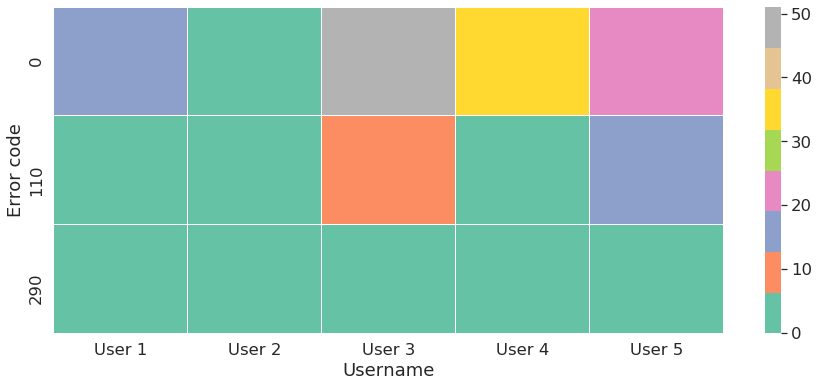

In [81]:
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1)
from matplotlib.colors import LogNorm
dummies_username = pd.get_dummies(df['User_name'])

df_pca3 = pd.concat([df.drop('User_name', axis = 1), dummies_username], axis=1)
df_scatter = df_pca3.groupby('error_code').sum()[dummies_username.columns]
log_norm = LogNorm(vmin=1.0, vmax=df_scatter.max().max())

sns.heatmap(df_scatter, lw = 0.1, cmap = 'Set2')
ax.set_xlabel('Username')
ax.set_ylabel('Error code')

In [82]:
LogNorm(1.0,1000.0)

In [83]:
df_scatter.min().min()

0

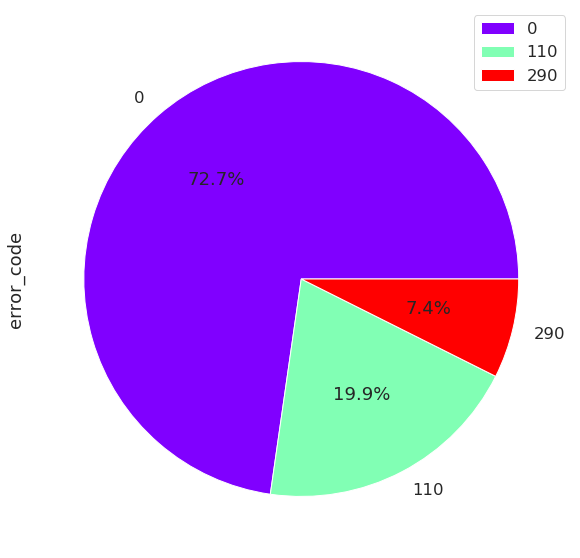

In [84]:
fig = plt.figure(figsize = (10,10))
df['error_code'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%',
                                                   cmap = 'rainbow')
state=['converged', 'not converged']
plt.legend(['converged', 'not converged'])
plt.legend(loc = 0)